In [1]:
from typing import List, Mapping
from itertools import zip_longest
from glob import glob

import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [2]:
run = 212
filenames = glob(f"/data/*/Run_{run:03d}/work/*.h5")
filenames

['/data/Step501N2/Run_212/work/reduced_--0200,dt=-7.000.h5',
 '/data/Step501N2/Run_212/work/reduced_--0200,dt=-6.970.h5',
 '/data/Step501N2/Run_212/work/reduced_--0200,dt=-6.940.h5',
 '/data/Step501N2/Run_212/work/reduced_--0200,dt=-6.910.h5']

In [4]:
def read_file(filename):
    with File(filename) as f:
        return {
            'delay': f['delay'].value,
            'df_n': f['df_n'][...],
            'df_img': f['df_img'][...],
        }


df = pd.DataFrame([read_file(fn) for fn in filenames])
df

,delay,df_img,df_n
0,-7.00,"[[2.5320602813511783, 3.091140446379967, 2.278...",3340
1,-6.97,"[[2.389625102069786, 2.9860167624847804, 2.299...",3290
2,-6.94,"[[2.5285990123416155, 3.068502039252067, 2.428...",3303
3,-6.91,"[[2.7564737473936987, 3.070113097870731, 2.754...",6650
4,-6.88,"[[2.9914762046942798, 3.5751714955842147, 2.61...",3267
5,-6.85,"[[2.8371734087735376, 3.2587501341028826, 2.36...",3331
6,-6.82,"[[2.4699248120300723, 3.5413533834586417, 3.36...",266


In [5]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 801), np.linspace(-np.pi, np.pi, 721)
r = (redges[1:] + redges[:-1]) / 2


def dist(img):
    img = img.T
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([437, 459]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist_indrdomega.sum(0), thedges, 6,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return hist_indrdth.sum(1)


df['dist'] = df['df_img'].apply(dist)

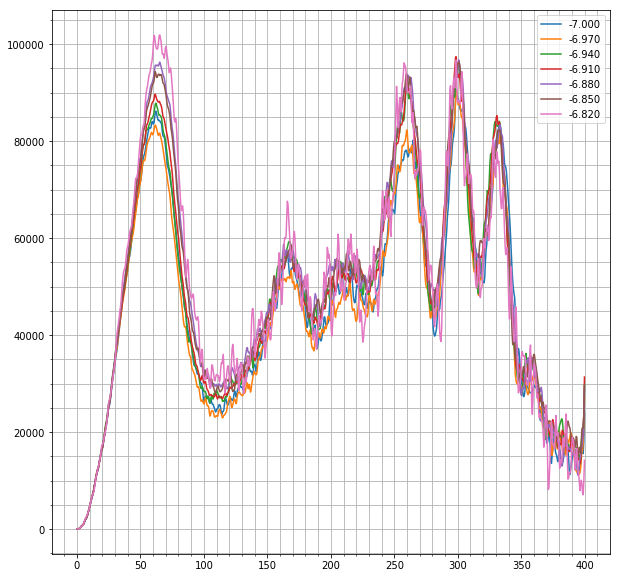

In [6]:
plt.figure(figsize=(10, 10))
for _, dt, dist in df[['delay', 'dist']].itertuples():
    plt.plot(r, dist, label=f"{dt:.3f}")
#     plt.plot(r**2, dist/2/r, label=f"{dt:.3f}")
plt.minorticks_on()
plt.grid(True, which='both')
plt.legend()
plt.show()

In [9]:
def intergrateit(dist, fr, to):
    where = (fr < r) & (r < to)
    return dist[where].sum()


df['summed1'] = df['dist'].apply(intergrateit, fr=0, to=110)
df['summed2'] = df['dist'].apply(intergrateit, fr=150, to=190)
df['summed3'] = df['dist'].apply(intergrateit, fr=190, to=230)
df['summed4'] = df['dist'].apply(intergrateit, fr=230, to=280)
df['summed5'] = df['dist'].apply(intergrateit, fr=280, to=315)
df['summed6'] = df['dist'].apply(intergrateit, fr=315, to=350)
df

,delay,df_img,df_n,dist,summed1,summed2,summed3,summed4,summed5,summed6
0,-7.00,"[[2.5320602813511783, 3.091140446379967, 2.278...",3340,"[0.9836638097431016, 11.523696376942187, 41.04...",9.592188e+06,3.819332e+06,3.775561e+06,6.294444e+06,4.694946e+06,4.312517e+06
1,-6.97,"[[2.389625102069786, 2.9860167624847804, 2.299...",3290,"[1.155574554847642, 13.555155966205923, 48.468...",9.260655e+06,3.680015e+06,3.616109e+06,6.259981e+06,4.689230e+06,4.086008e+06
2,-6.94,"[[2.5285990123416155, 3.068502039252067, 2.428...",3303,"[1.0910423276796344, 13.736252562550877, 52.05...",9.747678e+06,4.042523e+06,4.001929e+06,6.852382e+06,4.935490e+06,4.242296e+06
3,-6.91,"[[2.7564737473936987, 3.070113097870731, 2.754...",6650,"[1.5102206921171906, 16.605800697812427, 56.17...",9.984901e+06,3.963680e+06,4.029921e+06,6.903528e+06,5.009228e+06,4.294850e+06
4,-6.88,"[[2.9914762046942798, 3.5751714955842147, 2.61...",3267,"[1.6592938405970155, 17.02532931886519, 54.620...",1.071807e+07,4.096515e+06,4.176097e+06,7.178191e+06,5.010825e+06,4.262821e+06
5,-6.85,"[[2.8371734087735376, 3.2587501341028826, 2.36...",3331,"[1.0357715743188267, 12.686689263722329, 48.78...",1.057010e+07,4.040738e+06,4.146825e+06,7.143275e+06,5.038623e+06,4.191244e+06
6,-6.82,"[[2.4699248120300723, 3.5413533834586417, 3.36...",266,"[2.444079711501126, 21.598658772584713, 55.282...",1.128810e+07,4.018493e+06,4.015504e+06,7.029979e+06,4.910891e+06,3.961122e+06


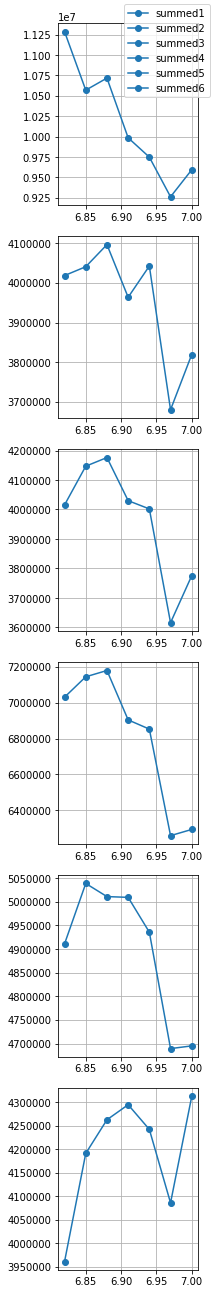

In [11]:
plt.figure(figsize=(3, 18))
for i in range(1, 7):
    plt.subplot(6, 1, i)
#     plt.title(f'{df["delay"]:.3f}')
    plt.plot(-df["delay"], df[f"summed{i}"], 'o-')
    plt.grid(True)
#     plt.ylim(0, None)
# plt.figlegend()
plt.tight_layout()
plt.show()